This is a simple ODE system solved with a PINN model using the DeepXDE library.
<br> 

\begin{equation}
\frac{\partial y_1}{\partial t} = y_2 \hspace{1cm} \frac{\partial y_2}{\partial t} = -y_1  \hspace{1cm} t∈[0,10]
\end{equation}
<br>

\begin{equation}
y_1(0) = 0 \hspace{1cm} y_2(0) = 1
\end{equation}



Test losses after 10000 epochs are approximately:

*In accordance to y outputs:* **1.16e-05**, **8.83e-06**

*In accordance to boundary conditions:* **6.53e-09**, **9.22e-09**

*In accordance to the known solution:* **7.05e-03**

In [1]:
# Importing libraries

!pip install deepxde
import deepxde as dde
import numpy as np

     |████████████████████████████████| 121 kB 14.6 MB/s 
     |████████████████████████████████| 100 kB 9.6 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
# Define computational geometry

geom = dde.geometry.TimeDomain(0, 10)

In [3]:
# Define ode system

def ode_system(x,y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    dy1_x = dde.grad.jacobian(y1, x)
    dy2_x = dde.grad.jacobian(y2, x)
    return [dy1_x - y2, dy2_x + y1]

In [4]:
# Define boundary conditions

def boundary(x, _):
    return np.isclose(x[0], 0)

ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)

In [5]:
# Define known solution

def sol(x):
    return np.hstack((np.sin(x), np.cos(x)))

In [6]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode_system, [ic1, ic2], num_domain=100, num_boundary=2, solution = sol, num_test=100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  total_n_samples))


In [7]:
# Create the neural network

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [8]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=10000)

Compiling model...

/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)



Building feed-forward neural network...
'build' took 0.138847 s

'compile' took 0.793463 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.84e-01, 1.26e-02, 0.00e+00, 1.00e+00]    [1.83e-01, 1.25e-02, 0.00e+00, 1.00e+00]    [1.15e+00]    
1000      [9.14e-03, 7.44e-03, 1.19e-06, 3.47e-04]    [9.58e-03, 7.11e-03, 1.19e-06, 3.47e-04]    [7.81e-01]    
2000      [5.59e-03, 4.77e-03, 5.25e-07, 1.41e-04]    [5.65e-03, 4.65e-03, 5.25e-07, 1.41e-04]    [6.25e-01]    
3000      [3.24e-03, 3.58e-03, 2.63e-08, 5.72e-05]    [3.32e-03, 3.42e-03, 2.63e-08, 5.72e-05]    [4.68e-01]    
4000      [1.51e-03, 2.38e-03, 3.53e-06, 2.83e-05]    [1.57e-03, 2.05e-03, 3.53e-06, 2.83e-05]    [3.23e-01]    
5000      [7.15e-04, 1.19e-03, 4.30e-07, 1.74e-05]    [7.12e-04, 9.18e-04, 4.30e-07, 1.74e-05]    [2.02e-01]    
6000      [2.69e-04, 4.24e-04, 5.30e-07, 4.63e-06]    [2.53e-04, 2.76e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


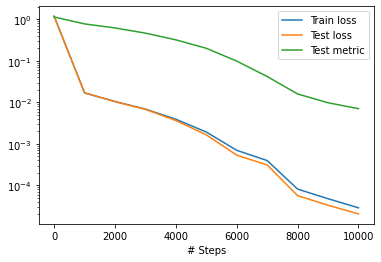

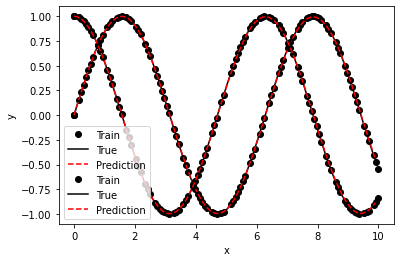

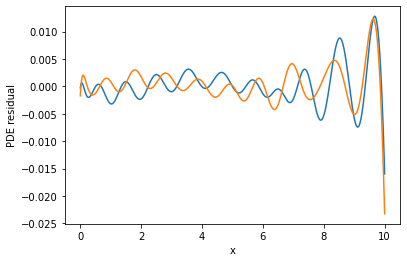

In [9]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode_system)

plt.figure()
plt.plot(x, y[0])
plt.plot(x, y[1])
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()